In [100]:
import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
#from keras.applications.vgg16 import VGG16

In [101]:
#tf.debugging.set_log_device_placement(True)
#gpus

In [102]:
IMAGE_SIZE = [256,256]

In [103]:
train_path="./removed/data_last/train"
test_path="./removed/data_last/test"
val_path="./removed/data_last/val"

# train_path="./data/train"
# test_path="./data/test"
# val_path="./data/val"


In [104]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(256,256))
        x_train.append(img_arr)
        
print('x-train done')

x-train done


In [105]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(256,256))
        x_test.append(img_arr)
print('x-test done')

x-test done


In [106]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(256,256))
        x_val.append(img_arr)
print('x-val done')   

x-val done


In [107]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)
print('test')

test


In [108]:
train_x.shape,test_x.shape,val_x.shape

((167, 256, 256, 3), (41, 256, 256, 3), (29, 256, 256, 3))

In [109]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [110]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [111]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (256,256),
                                                 batch_size = 32,
                                                 class_mode = 'input')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (256,256),
                                            batch_size = 32,
                                            class_mode = 'input')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (256,256),
                                            batch_size = 32,
                                            class_mode = 'input')

Found 167 images belonging to 3 classes.
Found 41 images belonging to 3 classes.
Found 29 images belonging to 3 classes.


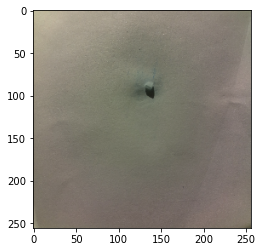

In [112]:
training_set.class_indices
plt.imshow(x_train[1])
#ims = x_train[260]
#PATH = './output_dir'
#x_train[0]
#cv2.imwrite('filename.jpeg', ims)

#ims.save("test_file.jpg")
#cv2.imwrite(path,img_to_save)

In [113]:
train_y=training_set.classes
print(train_y[0])
#0 = broken

#0 = chalky
#1 = damaged
#2 = discolored

0


In [114]:
test_y=test_set.classes

In [115]:
val_y=val_set.classes

In [116]:
train_y.shape,test_y.shape,val_y.shape

((167,), (41,), (29,))

In [117]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [118]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [119]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(3,activation='softmax')(x)

In [120]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [121]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [122]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [123]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=20,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/20
6/6 [==============================] - 12s 2s/step - loss: 1.4268 - accuracy: 0.4311 - val_loss: 0.8658 - val_accuracy: 0.6207
Epoch 2/20
6/6 [==============================] - 6s 1s/step - loss: 0.6325 - accuracy: 0.7365 - val_loss: 0.8089 - val_accuracy: 0.6207
Epoch 3/20
6/6 [==============================] - 6s 1s/step - loss: 0.4549 - accuracy: 0.8024 - val_loss: 0.6167 - val_accuracy: 0.7241
Epoch 4/20
6/6 [==============================] - 6s 1s/step - loss: 0.3196 - accuracy: 0.8683 - val_loss: 0.7179 - val_accuracy: 0.6897
Epoch 5/20
6/6 [==============================] - 6s 1s/step - loss: 0.2674 - accuracy: 0.9042 - val_loss: 0.4546 - val_accuracy: 0.7931
Epoch 6/20
6/6 [==============================] - 6s 1s/step - loss: 0.2452 - accuracy: 0.9042 - val_loss: 0.4507 - val_accuracy: 0.7931
Epoch 7/20
6/6 [==============================] - 6s 1s/step - loss: 0.2459 - accuracy: 0.9281 - val_loss: 0.5444 - val_accuracy: 0.7586
Epoch 8/20
6/6 [========================

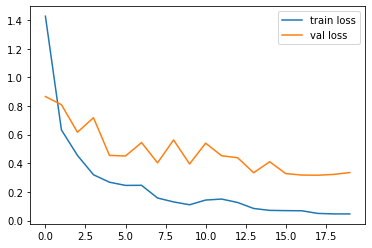

In [124]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

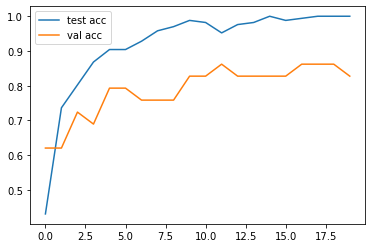

In [125]:
# accuracies
plt.plot(history.history['accuracy'], label='test acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [126]:
model.evaluate(test_x,test_y,batch_size=32)

2/2 [==============================] - 1s 269ms/step - loss: 0.4632 - accuracy: 0.7805


[0.46316054463386536, 0.7804877758026123]

In [127]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

2/2 [==============================] - 1s 1s/step


In [128]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_pred,test_y)

0.7804878048780488

In [129]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.86      0.63      0.73        19
           2       0.38      0.75      0.50         4

    accuracy                           0.78        41
   macro avg       0.71      0.78      0.72        41
weighted avg       0.83      0.78      0.79        41



In [130]:
import numpy as np

In [131]:
confusion_matrix(y_pred,test_y)

array([[17,  1,  0],
       [ 2, 12,  5],
       [ 0,  1,  3]], dtype=int64)

In [132]:
import tensorflow as tf
from keras.models import load_model

model.save('rice_quality_model_vgg19_ffinal_rep.h5')
